# Modeling Time Series Data Exercises

<hr style="border:2px solid gray">

### Exercises:
Use either the SAAS dataset or the store data and:

1. Split data (train/validate/test) and resample by any period except daily. Aggregate using the sum.
2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    - Simple Average
    - Moving Average
    - Holt's Linear Trend Model
    - Based on previous year/month/etc., this is up to you.
    
<hr style="border:1px solid black">

### Bonus Exercises:
Using the store data:

1. Predict 2018 total monthly sales for a single store and/or item by creating a model.
2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper). The upper and lower bounds of the predictions are auto generated when using the facebook prophet model, or you could calculate your own using, for example, bollinger bands.
3. Plot the 2018 monthly sales predictions.

In [1]:
#standard ds imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline
import seaborn as sns

#datetime imports
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

#visualization imports
from pandas.plotting import register_matplotlib_converters
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
import prepare
import model

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

<hr style="border:2px solid gray">
<hr style="border:2px solid gray">

## Exercises:
<b>Use either the SAAS dataset or the store data</b>

<b>Quick Preparation</b>
- change column names
- change datatype for ```month_invoice```
- set ```month_invoice``` to index
- create new columns
- changed ```amount``` and ```subscription_type``` datatype for float to int

In [2]:
saas_df = prepare.prep_saas_data()
saas_df.sample(3)

,customer_id,invoice_id,subscription_type,amount,month,day_of_week,year
month_invoiced,,,,,,,
2017-02-28,1025360,5645890,0,0,February,Tuesday,2017
2017-04-30,1023629,5673541,2,10,April,Sunday,2017
2017-09-30,1028460,5748180,0,0,September,Saturday,2017


<b> #1. Split data (train/validate/test) and resample by any period except daily. Aggregate using the sum.</b>

In [3]:
# set train size to be 50% of total 
train_size = int(len(saas_df) * 0.5)

# set validate size to be 30% of total 
validate_size = int(len(saas_df) * 0.3)

# set test size to be number of rows remaining. 
test_size = int(len(saas_df) - train_size - validate_size)

train_size, validate_size, test_size

(395229, 237137, 158092)

In [4]:
#get index
validate_end_index = train_size + validate_size
validate_end_index

632366

In [5]:
# train 
train = saas_df[:train_size]
# validate
validate = saas_df[train_size:validate_end_index]
# test 
test = saas_df[validate_end_index:]

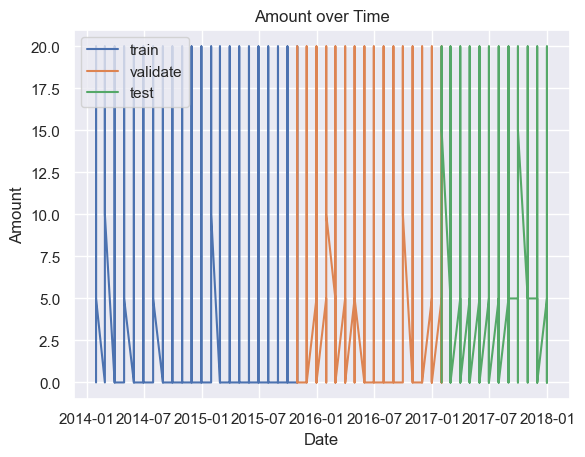

In [6]:
plt.plot(train.index, train.amount)
plt.plot(validate.index, validate.amount)
plt.plot(test.index, test.amount)

plt.title('Amount over Time')
plt.ylabel('Amount')
plt.xlabel('Date')
plt.legend(['train', 'validate', 'test'])
plt.show()

In [7]:
#define target
y = train.amount

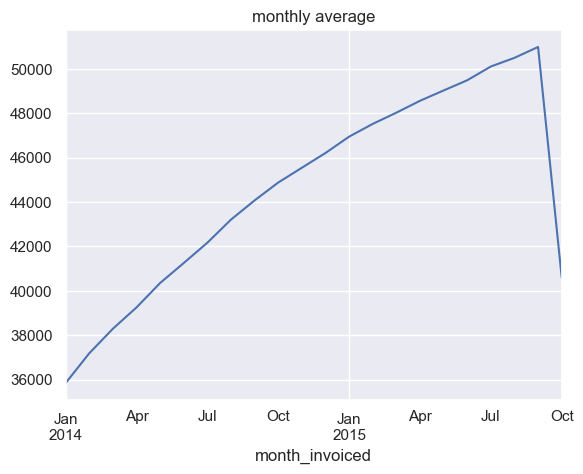

In [8]:
#resample every month and use average
y.resample('M').sum().plot(title='monthly average')
None

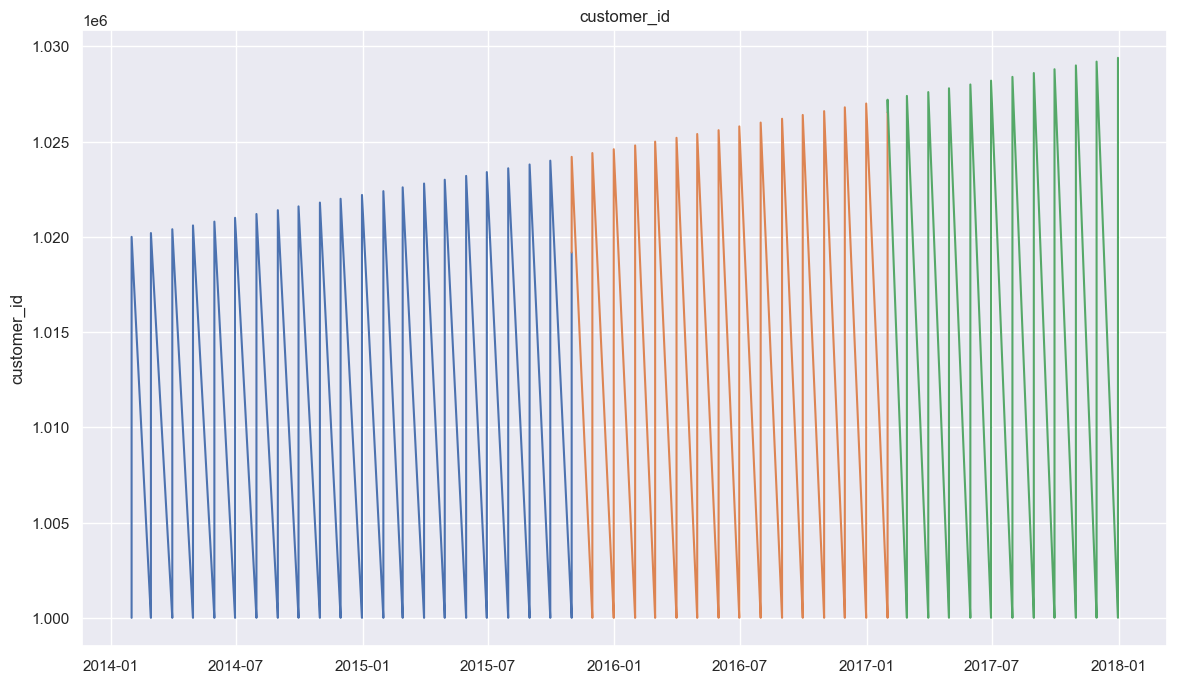

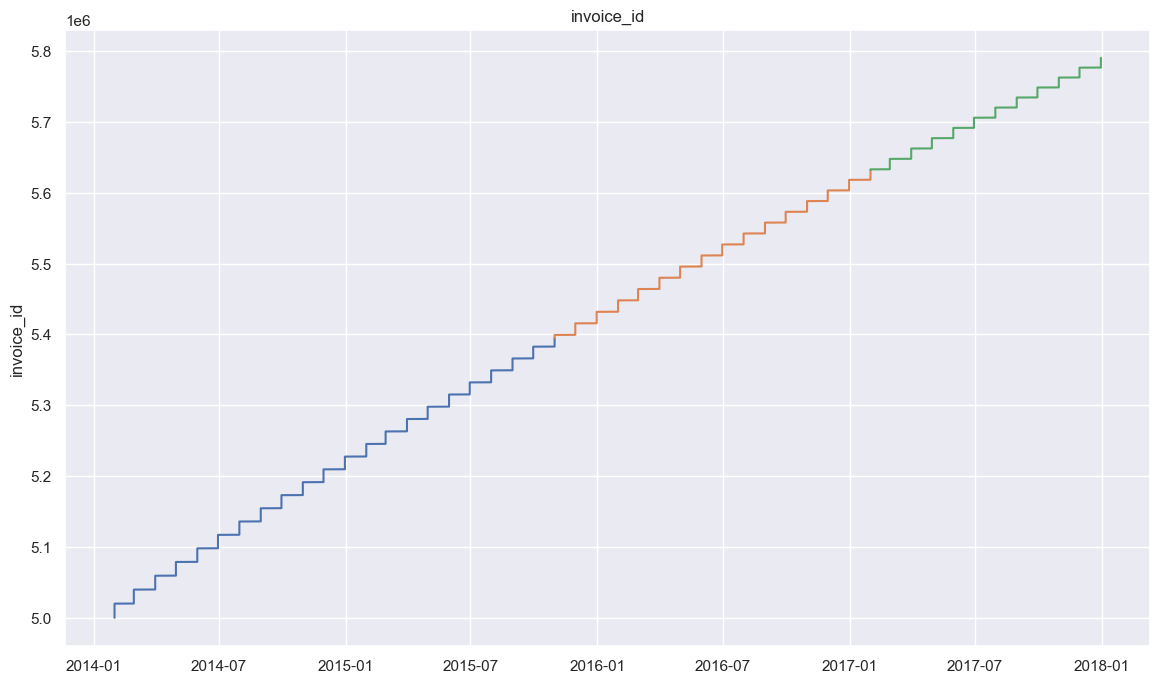

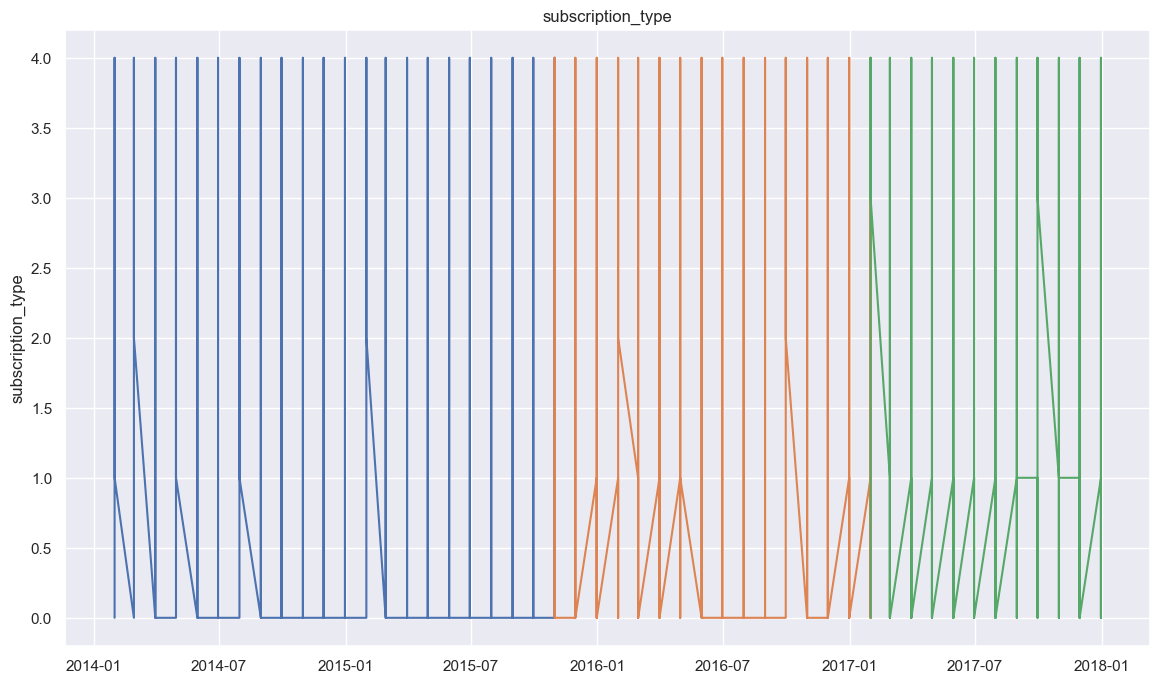

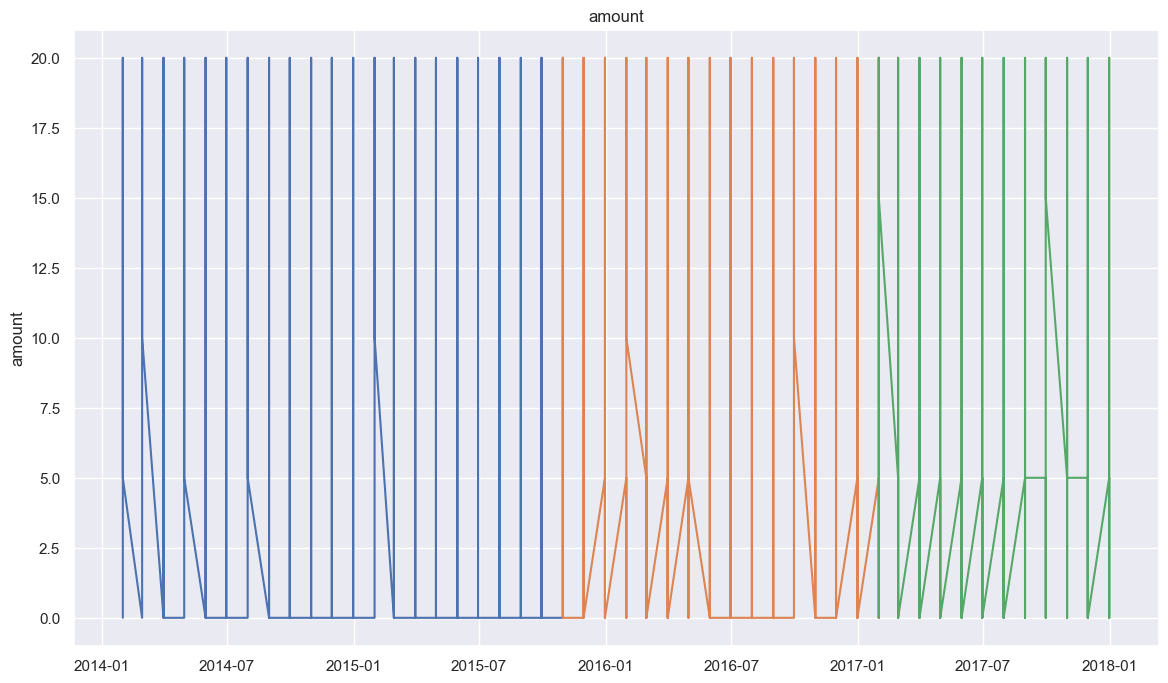

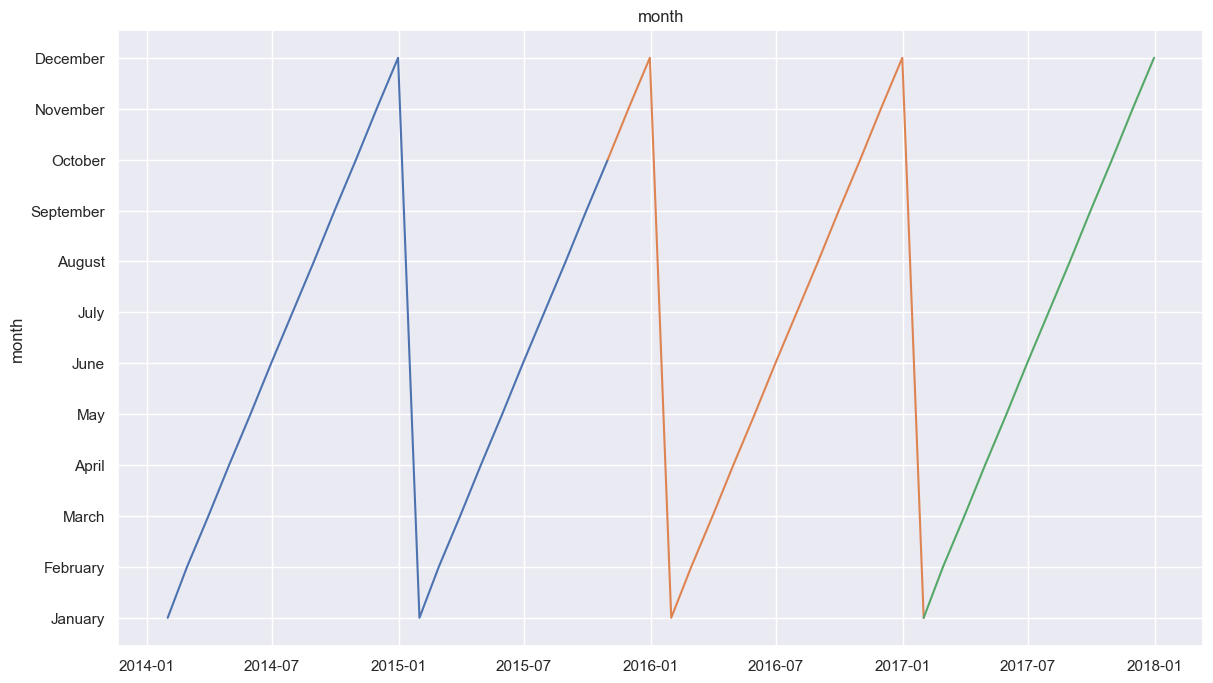

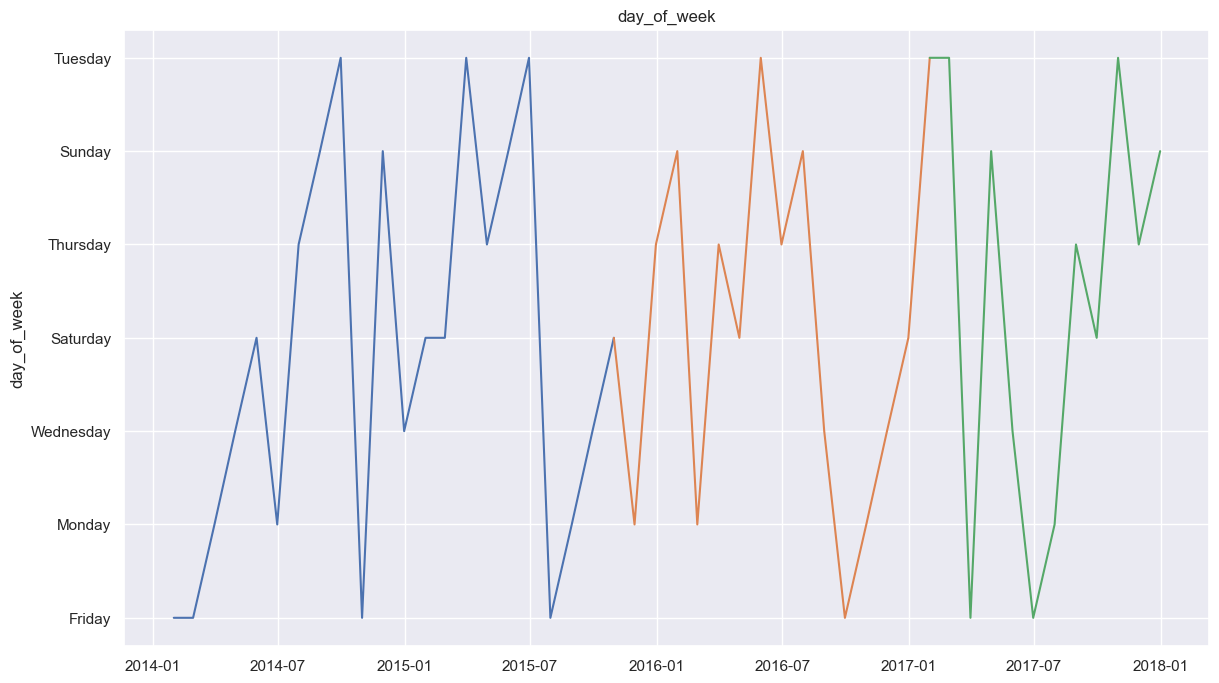

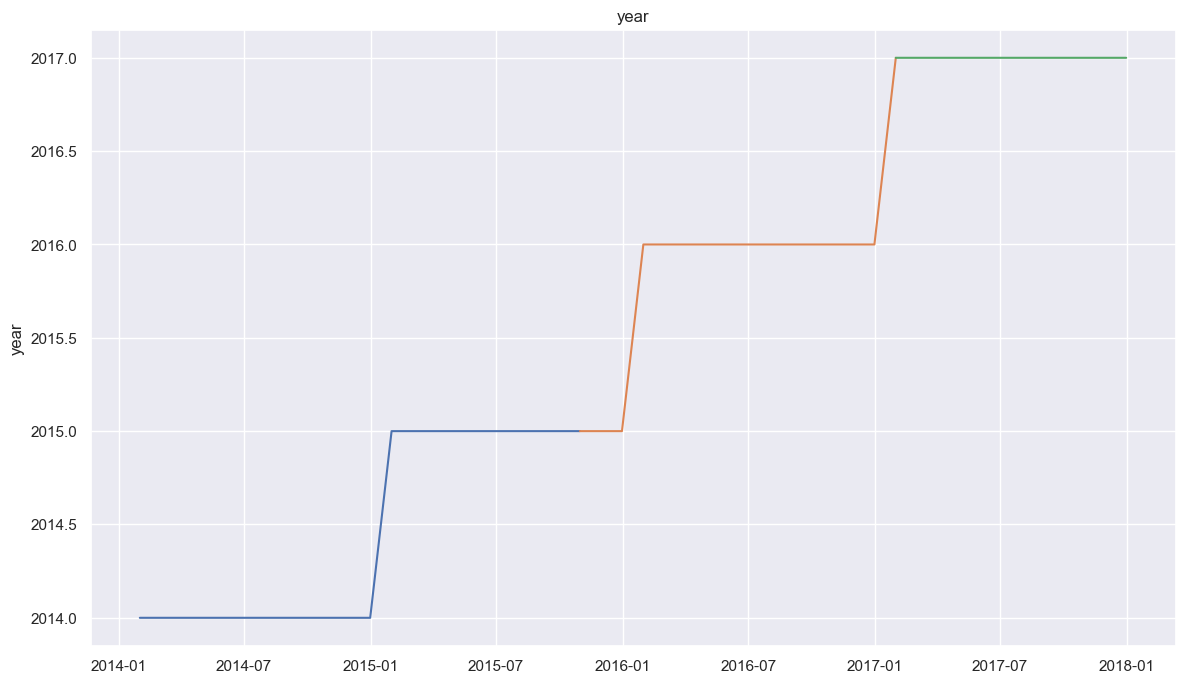

In [9]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

<b> #2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed</b>

In [10]:
#Create the empty dataframe and define the columns
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


<b>a. Simple Average </b>

In [11]:
#create df with average amount
#train set only
yhat_df = pd.DataFrame({'mean_predicted': train['amount'].mean()}, 
                      index = train.index)

In [12]:
yhat_df.sample(5)

,mean_predicted
month_invoiced,
2015-10-31,2.479676
2014-09-30,2.479676
2014-12-31,2.479676
2015-05-31,2.479676
2015-05-31,2.479676


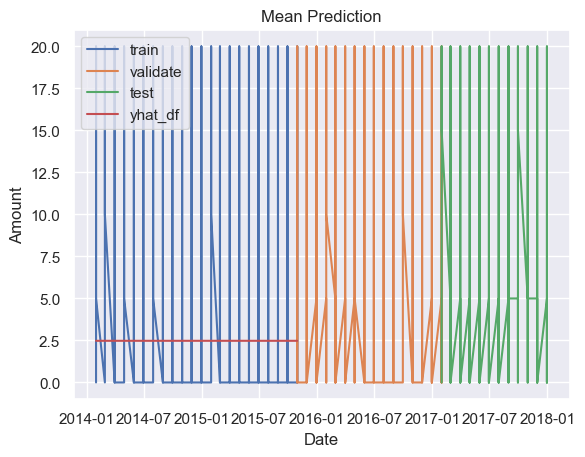

In [13]:
plt.plot(train['amount'])
plt.plot(validate['amount'])
plt.plot(test['amount'])
plt.plot(yhat_df['mean_predicted'])
plt.title('Mean Prediction')
plt.ylabel('Amount')
plt.xlabel('Date')
plt.legend(['train', 'validate', 'test', 'yhat_df'])
plt.show()
None

<div class="alert alert-block alert-info">
   
<b>Simple average</b> or yhat: takes the mean (average) of our target variable (amount) and uses that as a sort of "baseline" prediction.
<br>

- As we can see in the visual, our <u>simple average</u> prediction (red line) runs through the train set at almost 2.5
</div>

<b>b. Moving Average</b>

In [14]:
# moving Average
periods = [6, 12, 18, 24, 30, 36]

for p in periods: 
    prediction = round(train['amount'].rolling(p).mean()[-1], 2)

    yhat_df = pd.DataFrame({'Model': prediction},
                             index= train.index)

    model_type = str(p) + 'd_moving_avg'

In [15]:
yhat_df.sample(5)

,Model
month_invoiced,
2014-11-30,2.78
2015-03-31,2.78
2015-06-30,2.78
2014-07-31,2.78
2015-02-28,2.78


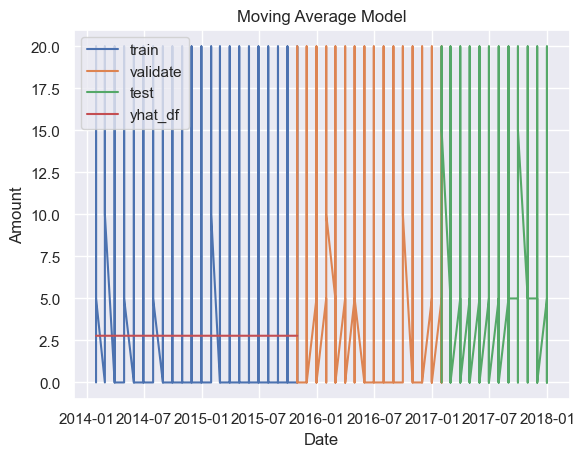

In [16]:
plt.plot(train['amount'])
plt.plot(validate['amount'])
plt.plot(test['amount'])
plt.plot(yhat_df['Model'])
plt.title('Moving Average Model')
plt.ylabel('Amount')
plt.xlabel('Date')
plt.legend(['train', 'validate', 'test', 'yhat_df'])
plt.show()
None

<div class="alert alert-block alert-info">
   
<b>Moving Average</b>:
<br>

- As we can see in the visual, our <u>moving average</u> prediction (red line) runs through the train set at almost 2.78
</div>

<b>c. Holt's Linear Trend Model</b>

In [17]:
import statsmodels.api as sm

In [18]:
col = 'amount' 
# create our Holt's Object
model = Holt(train[col], exponential=False, damped=True)

In [19]:
# fit the holt's object
model = model.fit(optimized=True)

In [20]:
yhat_items = model.predict(start = train.index[0],
                           end = train.index[-1])

In [21]:
# add predictions to yhat_df
yhat_df[col] = round(yhat_items, 2)

KeyboardInterrupt: 

In [ ]:
model.plot_and_eval(target = col)

In [ ]:
eval_df = model.append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [ ]:
eval_df.sort_values(by='rmse')

<b>d. Based on previous year/month/etc., this is up to you.</b>

<b>Re-split Data</b>

In [23]:
train = saas_df[:'2015']
validate = saas_df['2016']
test = saas_df['2017']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()

(431894, 7)
(186275, 7)
(172289, 7)


,customer_id,invoice_id,subscription_type,amount,month,day_of_week,year
month_invoiced,,,,,,,
2014-01-31,1000000,5000000,0,0,January,Friday,2014
2014-01-31,1000001,5000001,2,10,January,Friday,2014
2014-01-31,1000002,5000002,0,0,January,Friday,2014
2014-01-31,1000003,5000003,0,0,January,Friday,2014
2014-01-31,1000004,5000004,1,5,January,Friday,2014


<hr style="border:2px solid gray">
<hr style="border:2px solid gray">

## Bonus: 
<b>Using the store data</b>

<b> #1. Predict 2018 total monthly sales for a single store and/or item by creating a model.</b>

<b> #2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper). The upper and lower bounds of the predictions are auto generated when using the facebook prophet model, or you could calculate your own using, for example, bollinger bands.</b>

<b> #3. Plot the 2018 monthly sales predictions. </b>